In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
from torchvision.models import resnet18
import torchaudio.transforms as T
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    #os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    t = np.random.get_state()[1][0] + worker_id
    np.random.seed(t)
    random.seed(t)

In [3]:
device = torch.device('cuda:0')
data_dir = '/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/recordings'

In [4]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [5]:
NUM_SAMPLES = 11022
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
random_seed = 1
train_size = 0.8

In [6]:
recordings_old = sorted(os.listdir(data_dir))

In [7]:
recordings = []
for x in recordings_old:
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

In [8]:
len(recordings)

2903

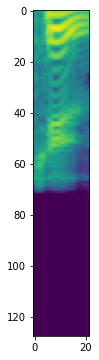

In [9]:
y, _ = librosa.load(data_dir + '/' + recordings[700], sr = sr)
samples = y[:NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec, ref=np.max)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [10]:
image_size = melspec.shape
image_size

(128, 22)

In [11]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def freq_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = 0.0
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = 0.0
    return image

def random_erasing(image, max_a = 12, max_b = 2):
    a = np.random.randint(max_a)
    b = np.random.randint(max_b)
    a0 = np.random.randint(image.shape[1] - a)
    b0 = np.random.randint(image.shape[2] - b)
    image[:, a0 : a0 + a, b0 : b0 + b] = 0.0
    return image

def loudness_conrol(image):
    min_value = torch.min(image)
    lyambda = np.random.rand() * 0.4
    image = min_value + lyambda * (image - min_value)
    return image
    
def FreqNoising(image, var = 0.1, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(image.shape[1] - a)
    noise = var * torch.randn(a, image.shape[2])
    image[0, a0: a0 + a, :] += noise
    image[1, a0: a0 + a, :] += noise
    image[2, a0: a0 + a, :] += noise
    return image

def TimeNoising(image, var = 0.1, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(image.shape[2] - b)
    noise = var * torch.randn(image.shape[1], b)
    image[0, :, b0: b0 + b] += noise
    image[1, :, b0: b0 + b] += noise
    image[2, :, b0: b0 + b] += noise
    return image

def TimeCycleShift(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def FreqCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, image.shape[1] - shift:, :].clone()
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = t
    else:
        t = image[:, :shift, :].clone()
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = t
    return image

def TimeSpecialShift(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
    return image

def FreqSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
    return image

def FreqSwapAugmentation(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - a)
    t = image[:, a0 : a0 + a, :].clone()
    image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    image[:, a0 - a: a0, :] = t
    return image

def TimeSwapAugmentation(image, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def FreqReplyMasking(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - 2 * a)
    p = np.random.rand()
    if p < 0.5:
        image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    else:
        image[:,  a0 : a0 + a, :] = image[:, a0 + a : a0 + 2 * a, :]
    return image

def TimeReplyMasking(image, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 2):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def FreqRandomSwap(image, max_a = 12):
    a = np.random.randint(max_a)
    a1 = np.random.randint(image.shape[1] - a)
    while True:
        a2 = np.random.randint(image.shape[1] - a)
        if np.abs(a1 - a2) >= a:
            t = image[:, a1 : a1 + a, :].clone()
            image[:, a1 : a1 + a, :] = image[:, a2 : a2 + a, :]
            image[:, a2 : a2 + a, :] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(2)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(12)(image)
    if mode == 'RandomErasing':
        return random_erasing(image, 12, 2)
    if mode == 'FreqShift':
        return freq_shift_augmentation(image)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'LoudnessControl':
        return loudness_conrol(image)
    if mode == 'TimeNoising':
        return TimeNoising(image)
    if mode == 'FreqNoising':
        return FreqNoising(image)
    if mode == 'FreqCycleShift':
        return FreqCycleShift(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'FreqSpecialShift':
        return FreqSpecialShift(image)
    if mode == 'TimeSpecialShift':
        return TimeSpecialShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'FreqSwapAugmentation':
        return FreqSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'FreqReplyMasking':
        return FreqReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)
    if mode == 'FreqRandomSwap':
        return FreqRandomSwap(image)
    
    
    return image

In [12]:
def get_spectrogram(filename):
    y, _ = librosa.load(filename, sr = sr)
    samples = y[:NUM_SAMPLES]
    melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
    melspec = librosa.power_to_db(melspec)
    melspec = normalize(melspec, mean=None, std=None)
    return torch.tensor(melspec, dtype=torch.float32)

In [13]:
data = []
labels = []
for i in range(len(recordings)):
    data.append(get_spectrogram(data_dir + '/' + recordings[i]))
    labels.append(int(recordings[i][0]))

In [14]:
keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

In [15]:
class AudioMNIST(Dataset):
    def __init__(self, keys, mode = 'train', data = [], labels = [], augment = False, aug_type = 'No'):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        self.augment = augment
        self.aug_type = aug_type
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        if self.augment:
            X = augmentation(X, self.aug_type)
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [16]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, augment = 'No'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    for epoch in range(epochs):
        print('epoch:', epoch)
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)

        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        print('Train')
        print(mean_loss)

        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)

        print('TEST')
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        print('loss:', mean_loss)
        print('accuracy:', mean_accuracy)
        print('******************')
    print('Accuracy on the validation: ', best_acc)
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses, valid_acc

In [17]:
def evaluate(model, test_loader):
    model.eval()
    #all_preds = []
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)
            #all_preds.append(preds)

    mean_accuracy = sum_accuracy / cnt_objects
    print('Quality of the model')
    print('accuracy:', mean_accuracy)

## Resnet18

### No augmentation

In [18]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = False, keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch: 0
Train
0.9277079448176123
TEST
loss: 0.516153407737773
accuracy: 0.843010752688172
******************
epoch: 1
Train
0.352403101256026
TEST
loss: 0.37077172046066614
accuracy: 0.875268817204301
******************
epoch: 2
Train
0.2891412992020352
TEST
loss: 0.1950610405815545
accuracy: 0.9225806451612903
******************
epoch: 3
Train
0.210257956367959
TEST
loss: 0.47084046435612503
accuracy: 0.8688172043010752
******************
epoch: 4
Train
0.20459607848571587
TEST
loss: 0.45068418415643835
accuracy: 0.864516129032258
******************
epoch: 5
Train
0.18919586409916464
TEST
loss: 0.4980367373715165
accuracy: 0.8731182795698925
******************
epoch: 6
Train
0.20646511368938975
TEST
loss: 0.24816764336760327
accuracy: 0.9247311827956989
******************
epoch: 7
Train
0.12946733187204032
TEST
loss: 0.14548909805154286
accuracy: 0.9440860215053763
******************
epoch: 8
Train
0.1511414637232443
TEST
loss: 0.20766193302728797
accuracy: 0.9311827956989247
*******

In [19]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9535283993115319


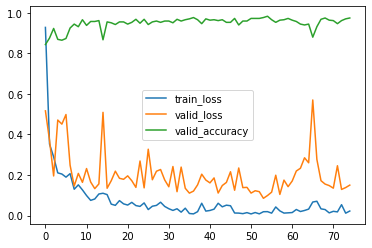

In [20]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeMasking

In [21]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.0707515691902025
TEST
loss: 0.8134310901805919
accuracy: 0.7698924731182796
******************
epoch: 1
Train
0.40346048991398975
TEST
loss: 0.4483091180042554
accuracy: 0.875268817204301
******************
epoch: 2
Train
0.2945922552159093
TEST
loss: 0.2966358571924189
accuracy: 0.8946236559139785
******************
epoch: 3
Train
0.23884892919465425
TEST
loss: 0.20127107001120045
accuracy: 0.9290322580645162
******************
epoch: 4
Train
0.2315180737226319
TEST
loss: 0.7054440882898146
accuracy: 0.7784946236559139
******************
epoch: 5
Train
0.23840332092234828
TEST
loss: 0.28726819817737864
accuracy: 0.9139784946236559
******************
epoch: 6
Train
0.15879840108901502
TEST
loss: 0.13307526617921808
accuracy: 0.9505376344086022
******************
epoch: 7
Train
0.19690330239092077
TEST
loss: 0.33496252388082526
accuracy: 0.8989247311827957
******************
epoch: 8
Train
0.1339122973458704
TEST
loss: 0.18391968308277026
ac

In [22]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9432013769363167


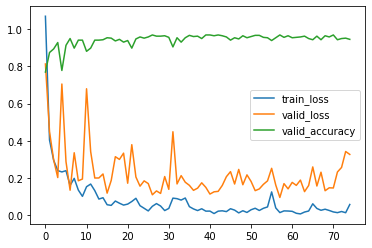

In [23]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqMasking

In [24]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.031512064130061
TEST
loss: 0.9561948040480255
accuracy: 0.7505376344086021
******************
epoch: 1
Train
0.4295116984593849
TEST
loss: 0.45564327630945434
accuracy: 0.8580645161290322
******************
epoch: 2
Train
0.3486967903346738
TEST
loss: 0.30808490309664
accuracy: 0.9032258064516129
******************
epoch: 3
Train
0.26859262102575926
TEST
loss: 0.31627263989980503
accuracy: 0.9096774193548387
******************
epoch: 4
Train
0.2588165809726869
TEST
loss: 0.25244080981900613
accuracy: 0.9182795698924732
******************
epoch: 5
Train
0.27560141982734365
TEST
loss: 0.3153363263735207
accuracy: 0.9118279569892473
******************
epoch: 6
Train
0.17631888959314082
TEST
loss: 0.33068242393514163
accuracy: 0.9032258064516129
******************
epoch: 7
Train
0.1831410562375828
TEST
loss: 0.23120252092679341
accuracy: 0.9333333333333333
******************
epoch: 8
Train
0.1409646260783309
TEST
loss: 0.23875718116760253
accur

In [25]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9500860585197934


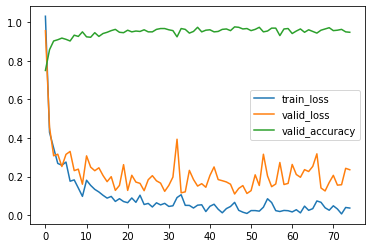

In [26]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### Noise

In [27]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'Noise', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.031744730491823
TEST
loss: 1.0770089818585304
accuracy: 0.7311827956989247
******************
epoch: 1
Train
0.38410836544868826
TEST
loss: 0.470190034245932
accuracy: 0.8301075268817204
******************
epoch: 2
Train
0.293907802080556
TEST
loss: 0.3216281513373057
accuracy: 0.9182795698924732
******************
epoch: 3
Train
0.1799880922899878
TEST
loss: 0.3353001953453146
accuracy: 0.875268817204301
******************
epoch: 4
Train
0.2773113165995609
TEST
loss: 0.5715664056039625
accuracy: 0.864516129032258
******************
epoch: 5
Train
0.18240369807409226
TEST
loss: 0.24739102937521473
accuracy: 0.9290322580645162
******************
epoch: 6
Train
0.22461070536796804
TEST
loss: 0.21048633219093404
accuracy: 0.9290322580645162
******************
epoch: 7
Train
0.15492915162314122
TEST
loss: 0.2050961224622624
accuracy: 0.946236559139785
******************
epoch: 8
Train
0.1075855920960907
TEST
loss: 0.23154060263787546
accuracy: 

In [28]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9586919104991394


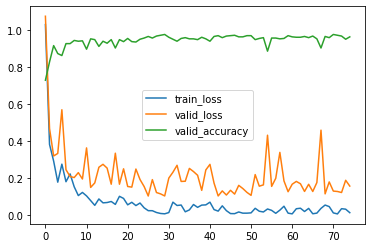

In [29]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### RandomErasing

In [30]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'RandomErasing', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.9285693410011665
TEST
loss: 0.5312153085585564
accuracy: 0.8688172043010752
******************
epoch: 1
Train
0.42652004742147337
TEST
loss: 0.3440461897080944
accuracy: 0.9118279569892473
******************
epoch: 2
Train
0.24102504399751037
TEST
loss: 0.22994798146268372
accuracy: 0.9225806451612903
******************
epoch: 3
Train
0.2107892504897757
TEST
loss: 0.32663191890203824
accuracy: 0.9161290322580645
******************
epoch: 4
Train
0.1947786407118917
TEST
loss: 0.3341410160064697
accuracy: 0.9225806451612903
******************
epoch: 5
Train
0.20235023939230778
TEST
loss: 0.2264585054048928
accuracy: 0.9268817204301075
******************
epoch: 6
Train
0.19554254061185872
TEST
loss: 0.16952191450262583
accuracy: 0.9397849462365592
******************
epoch: 7
Train
0.12384397932516354
TEST
loss: 0.20027060226727558
accuracy: 0.9225806451612903
******************
epoch: 8
Train
0.14513209852147757
TEST
loss: 0.2846448026677614
a

In [31]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9672977624784854


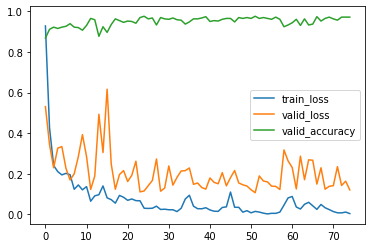

In [32]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeShift

In [33]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.0233987962037694
TEST
loss: 0.8382617683820827
accuracy: 0.789247311827957
******************
epoch: 1
Train
0.4728327840004933
TEST
loss: 0.3341001292710663
accuracy: 0.8881720430107527
******************
epoch: 2
Train
0.30763325809341124
TEST
loss: 0.2725490038753838
accuracy: 0.9182795698924732
******************
epoch: 3
Train
0.20958478366038333
TEST
loss: 0.32160640801152873
accuracy: 0.9118279569892473
******************
epoch: 4
Train
0.26901250445335606
TEST
loss: 0.4279169233896399
accuracy: 0.8688172043010752
******************
epoch: 5
Train
0.26759834528996473
TEST
loss: 0.17033758214724962
accuracy: 0.9290322580645162
******************
epoch: 6
Train
0.23851436431137027
TEST
loss: 0.3665132990447424
accuracy: 0.8881720430107527
******************
epoch: 7
Train
0.18066359481056596
TEST
loss: 0.27343543127018916
accuracy: 0.9311827956989247
******************
epoch: 8
Train
0.1797570438878024
TEST
loss: 0.17282290535588418
ac

In [34]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9690189328743546


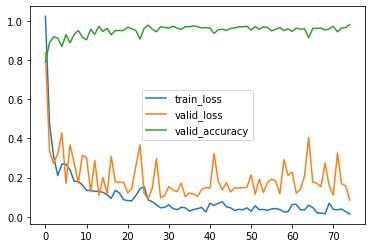

In [35]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqShift

In [36]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.8954945789849686
TEST
loss: 0.9958693691479262
accuracy: 0.6580645161290323
******************
epoch: 1
Train
1.3747845848337192
TEST
loss: 0.7237906599557528
accuracy: 0.7397849462365591
******************
epoch: 2
Train
1.2718254720644728
TEST
loss: 0.6930772409644178
accuracy: 0.7913978494623656
******************
epoch: 3
Train
1.136114744454478
TEST
loss: 0.674077812446061
accuracy: 0.7806451612903226
******************
epoch: 4
Train
1.114900097515741
TEST
loss: 0.55833367506663
accuracy: 0.8064516129032258
******************
epoch: 5
Train
0.9966876251311089
TEST
loss: 0.3147482269553728
accuracy: 0.8774193548387097
******************
epoch: 6
Train
1.0415059507182034
TEST
loss: 0.4060440428795353
accuracy: 0.8516129032258064
******************
epoch: 7
Train
0.9868574976985276
TEST
loss: 0.433318845559192
accuracy: 0.8602150537634409
******************
epoch: 8
Train
0.9023469163322552
TEST
loss: 0.18904317335415913
accuracy: 0.9333

In [37]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9432013769363167


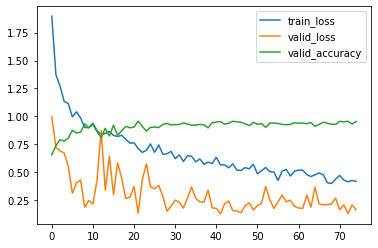

In [38]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### LoudnessControl

In [39]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'LoudnessControl', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.5541633790580573
TEST
loss: 1.240429065560782
accuracy: 0.5741935483870968
******************
epoch: 1
Train
0.8094767060534057
TEST
loss: 0.6075798599950729
accuracy: 0.7569892473118279
******************
epoch: 2
Train
0.4790925586743578
TEST
loss: 0.8256801187351186
accuracy: 0.7225806451612903
******************
epoch: 3
Train
0.43587926144104333
TEST
loss: 0.35471847044524324
accuracy: 0.8817204301075269
******************
epoch: 4
Train
0.3489415103797317
TEST
loss: 0.3480885172402987
accuracy: 0.8924731182795699
******************
epoch: 5
Train
0.31784802325386863
TEST
loss: 0.48932969288159445
accuracy: 0.8709677419354839
******************
epoch: 6
Train
0.3854232744690418
TEST
loss: 0.3590499028082817
accuracy: 0.8881720430107527
******************
epoch: 7
Train
0.27389174529667754
TEST
loss: 0.3725637841609217
accuracy: 0.8924731182795699
******************
epoch: 8
Train
0.2506166849331504
TEST
loss: 0.3051219699203327
accurac

In [40]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9449225473321858


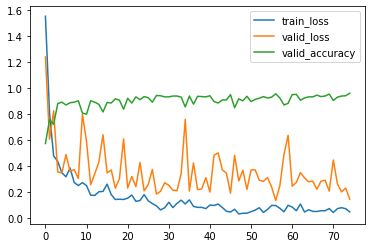

In [41]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeNoising

In [42]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeNoising', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.0571073741121966
TEST
loss: 0.4958476815172421
accuracy: 0.8279569892473119
******************
epoch: 1
Train
0.37143678946333286
TEST
loss: 0.5796732097543696
accuracy: 0.8236559139784946
******************
epoch: 2
Train
0.3260340859444474
TEST
loss: 0.7861280341302195
accuracy: 0.7698924731182796
******************
epoch: 3
Train
0.22622046746839164
TEST
loss: 0.23809821797955422
accuracy: 0.9247311827956989
******************
epoch: 4
Train
0.22673651282352084
TEST
loss: 0.4011699406049585
accuracy: 0.8989247311827957
******************
epoch: 5
Train
0.16865245437005802
TEST
loss: 0.1386629145632508
accuracy: 0.9526881720430107
******************
epoch: 6
Train
0.15097300297849975
TEST
loss: 0.2888930533521919
accuracy: 0.9268817204301075
******************
epoch: 7
Train
0.1305809638788447
TEST
loss: 0.3257364081278924
accuracy: 0.8946236559139785
******************
epoch: 8
Train
0.10758488506126866
TEST
loss: 0.17542495099447106
acc

In [43]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9604130808950087


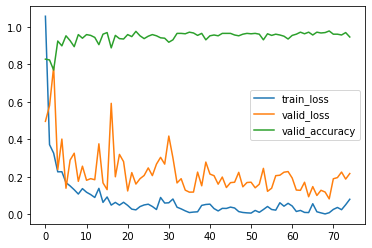

In [44]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqNoising

In [45]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqNoising', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.9763068195049264
TEST
loss: 1.135825595548076
accuracy: 0.7483870967741936
******************
epoch: 1
Train
0.3586955708589487
TEST
loss: 1.5614640917829288
accuracy: 0.6903225806451613
******************
epoch: 2
Train
0.2917845188833143
TEST
loss: 0.4029064933458964
accuracy: 0.8946236559139785
******************
epoch: 3
Train
0.2555805276527672
TEST
loss: 0.6590234277068928
accuracy: 0.8086021505376344
******************
epoch: 4
Train
0.23846162334044388
TEST
loss: 0.47595797341356993
accuracy: 0.853763440860215
******************
epoch: 5
Train
0.1690420355360933
TEST
loss: 0.25145541237246605
accuracy: 0.9096774193548387
******************
epoch: 6
Train
0.1287639166559978
TEST
loss: 0.19370856156913183
accuracy: 0.9440860215053763
******************
epoch: 7
Train
0.1447415186707121
TEST
loss: 0.5439312434324655
accuracy: 0.853763440860215
******************
epoch: 8
Train
0.1604617540802311
TEST
loss: 0.24330273917926254
accuracy:

In [46]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9569707401032702


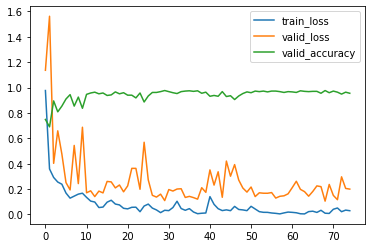

In [47]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeCycleShift

In [48]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeCycleShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.042651519123174
TEST
loss: 0.5373003716109901
accuracy: 0.8150537634408602
******************
epoch: 1
Train
0.44834851563843464
TEST
loss: 0.36712261451187955
accuracy: 0.8688172043010752
******************
epoch: 2
Train
0.30185057055134895
TEST
loss: 0.2658944551021822
accuracy: 0.8989247311827957
******************
epoch: 3
Train
0.2246724686509637
TEST
loss: 0.42448866110976025
accuracy: 0.875268817204301
******************
epoch: 4
Train
0.24750101007822065
TEST
loss: 0.31408945379718656
accuracy: 0.9139784946236559
******************
epoch: 5
Train
0.23735820447878614
TEST
loss: 0.4609798123759608
accuracy: 0.8580645161290322
******************
epoch: 6
Train
0.23984498632936369
TEST
loss: 0.16500980687397782
accuracy: 0.9440860215053763
******************
epoch: 7
Train
0.1603714949865141
TEST
loss: 0.11792686600838938
accuracy: 0.9634408602150538
******************
epoch: 8
Train
0.19377349115663403
TEST
loss: 0.3664210555373981
ac

In [49]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9724612736660929


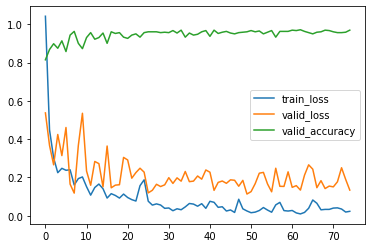

In [50]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqCycleShift

In [51]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqCycleShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.8297199157854531
TEST
loss: 2.3636382651585404
accuracy: 0.5376344086021505
******************
epoch: 1
Train
1.335209815169639
TEST
loss: 0.686037451477461
accuracy: 0.7784946236559139
******************
epoch: 2
Train
1.2374139741087191
TEST
loss: 1.0207988769777359
accuracy: 0.7075268817204301
******************
epoch: 3
Train
1.1370372651531033
TEST
loss: 1.2905814014455324
accuracy: 0.6494623655913978
******************
epoch: 4
Train
1.0709738563836488
TEST
loss: 0.9296072808645105
accuracy: 0.7548387096774194
******************
epoch: 5
Train
0.9951509797707898
TEST
loss: 0.7073686310040054
accuracy: 0.7849462365591398
******************
epoch: 6
Train
1.0392356542855357
TEST
loss: 0.39838895733638474
accuracy: 0.8580645161290322
******************
epoch: 7
Train
0.9900585363549318
TEST
loss: 0.6853401150754703
accuracy: 0.8021505376344086
******************
epoch: 8
Train
0.9640075470981382
TEST
loss: 0.2720281925893599
accuracy: 0.

In [52]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9363166953528399


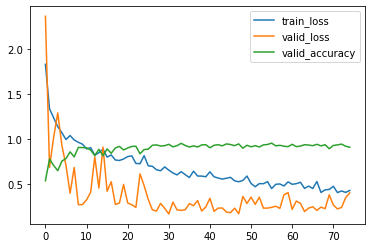

In [53]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSpecialShift

In [54]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSpecialShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.0345312132909854
TEST
loss: 0.7543783605739635
accuracy: 0.7870967741935484
******************
epoch: 1
Train
0.4707266386953425
TEST
loss: 0.3884724361922151
accuracy: 0.8666666666666667
******************
epoch: 2
Train
0.29861081680047236
TEST
loss: 0.14336924806076992
accuracy: 0.9483870967741935
******************
epoch: 3
Train
0.2705724374157932
TEST
loss: 0.22963509380176503
accuracy: 0.9268817204301075
******************
epoch: 4
Train
0.2593963934518858
TEST
loss: 0.2015938021803415
accuracy: 0.9311827956989247
******************
epoch: 5
Train
0.21492360743323385
TEST
loss: 0.4551832260624055
accuracy: 0.8688172043010752
******************
epoch: 6
Train
0.23216109662269094
TEST
loss: 0.23804671911783115
accuracy: 0.9075268817204301
******************
epoch: 7
Train
0.14601927828775918
TEST
loss: 0.16547761296713223
accuracy: 0.9483870967741935
******************
epoch: 8
Train
0.1908437085203028
TEST
loss: 0.3618051452021445
acc

In [55]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9672977624784854


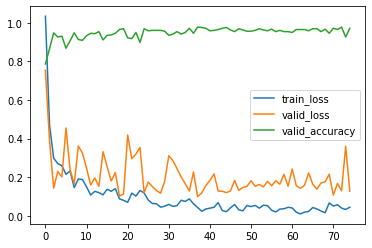

In [56]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSpecialShift

In [57]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSpecialShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.8777342598863231
TEST
loss: 5.159811136799474
accuracy: 0.24516129032258063
******************
epoch: 1
Train
1.3590119987902747
TEST
loss: 1.0387608287154988
accuracy: 0.7311827956989247
******************
epoch: 2
Train
1.2447132333735977
TEST
loss: 1.164082992717784
accuracy: 0.7440860215053764
******************
epoch: 3
Train
1.1238654965537815
TEST
loss: 1.5496240697881227
accuracy: 0.6344086021505376
******************
epoch: 4
Train
1.0311434012173195
TEST
loss: 0.8890629426125557
accuracy: 0.7591397849462366
******************
epoch: 5
Train
1.0071188490687357
TEST
loss: 0.4661860654431005
accuracy: 0.8408602150537634
******************
epoch: 6
Train
1.0495461242842175
TEST
loss: 0.8223770685093377
accuracy: 0.810752688172043
******************
epoch: 7
Train
0.9368133291995326
TEST
loss: 0.6238476919871505
accuracy: 0.7978494623655914
******************
epoch: 8
Train
0.9617141185425659
TEST
loss: 0.45761100348605904
accuracy: 0.

In [58]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9449225473321858


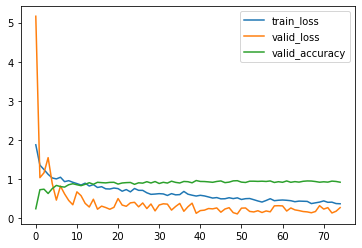

In [59]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSwapAugmentation

In [60]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSwapAugmentation', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.0010730116099007
TEST
loss: 0.858489970109796
accuracy: 0.7440860215053764
******************
epoch: 1
Train
0.43931715977596353
TEST
loss: 0.3044634683157808
accuracy: 0.9053763440860215
******************
epoch: 2
Train
0.23697391998145165
TEST
loss: 0.23979553790182195
accuracy: 0.9139784946236559
******************
epoch: 3
Train
0.21956953112643832
TEST
loss: 0.46174147071376925
accuracy: 0.864516129032258
******************
epoch: 4
Train
0.18038359667963408
TEST
loss: 0.17977275290796835
accuracy: 0.9397849462365592
******************
epoch: 5
Train
0.19507087907549767
TEST
loss: 0.18495438726999427
accuracy: 0.9376344086021505
******************
epoch: 6
Train
0.23362987052386464
TEST
loss: 0.44653266203659836
accuracy: 0.8817204301075269
******************
epoch: 7
Train
0.11861980964435193
TEST
loss: 0.2450455976750261
accuracy: 0.9397849462365592
******************
epoch: 8
Train
0.14623454519671397
TEST
loss: 0.10781336865758383

In [61]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9535283993115319


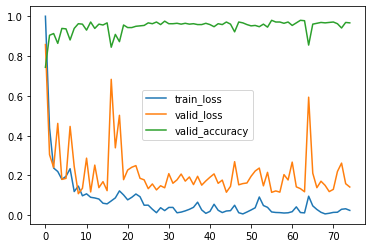

In [62]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSwapAugmentation

In [63]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSwapAugmentation', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.0941818589861185
TEST
loss: 1.1677495525729271
accuracy: 0.7075268817204301
******************
epoch: 1
Train
0.5136761095296586
TEST
loss: 0.6399740512653064
accuracy: 0.810752688172043
******************
epoch: 2
Train
0.27974628426403403
TEST
loss: 0.33958555421521586
accuracy: 0.8774193548387097
******************
epoch: 3
Train
0.34301689047292155
TEST
loss: 0.7434046764527598
accuracy: 0.8129032258064516
******************
epoch: 4
Train
0.26992981334045874
TEST
loss: 0.4332804886243677
accuracy: 0.8494623655913979
******************
epoch: 5
Train
0.2588035486433926
TEST
loss: 0.23913911351914047
accuracy: 0.9118279569892473
******************
epoch: 6
Train
0.23627039952244755
TEST
loss: 0.245582385921991
accuracy: 0.9139784946236559
******************
epoch: 7
Train
0.16700623988078112
TEST
loss: 0.23566609404740796
accuracy: 0.9247311827956989
******************
epoch: 8
Train
0.18773637354919587
TEST
loss: 0.3868461061549443
accu

In [64]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9535283993115319


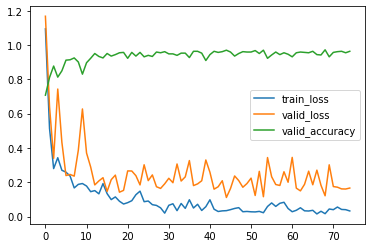

In [65]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeReplyMasking

In [66]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeReplyMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.927228344982519
TEST
loss: 0.8620253470636183
accuracy: 0.7376344086021506
******************
epoch: 1
Train
0.37729098454045557
TEST
loss: 0.4131085234303628
accuracy: 0.8580645161290322
******************
epoch: 2
Train
0.21280387247770655
TEST
loss: 0.2829835974881726
accuracy: 0.9139784946236559
******************
epoch: 3
Train
0.2410561798975939
TEST
loss: 0.49277763558972265
accuracy: 0.8688172043010752
******************
epoch: 4
Train
0.21823947283293396
TEST
loss: 0.17678269622146442
accuracy: 0.9440860215053763
******************
epoch: 5
Train
0.17197440875173578
TEST
loss: 0.1719228938702614
accuracy: 0.9354838709677419
******************
epoch: 6
Train
0.17440654227472982
TEST
loss: 0.7895332879917596
accuracy: 0.8021505376344086
******************
epoch: 7
Train
0.11528054455081557
TEST
loss: 0.14610249643684714
accuracy: 0.9505376344086022
******************
epoch: 8
Train
0.10574732594067651
TEST
loss: 0.2604283461647649
ac

In [67]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9604130808950087


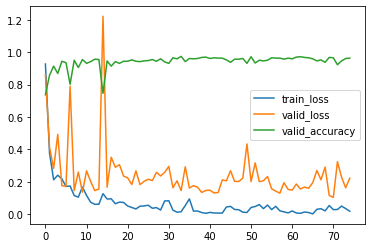

In [68]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqReplyMasking

In [69]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqReplyMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.0600676334989154
TEST
loss: 1.0201155562554636
accuracy: 0.7354838709677419
******************
epoch: 1
Train
0.44873672200584513
TEST
loss: 0.3918024592502143
accuracy: 0.8602150537634409
******************
epoch: 2
Train
0.29198576380761004
TEST
loss: 0.49069580749798847
accuracy: 0.8559139784946237
******************
epoch: 3
Train
0.34781935116136725
TEST
loss: 0.6497920681071537
accuracy: 0.8258064516129032
******************
epoch: 4
Train
0.2502918102982613
TEST
loss: 0.4633474103866085
accuracy: 0.8559139784946237
******************
epoch: 5
Train
0.22954551642083582
TEST
loss: 0.33366356049814533
accuracy: 0.9139784946236559
******************
epoch: 6
Train
0.20726916895287617
TEST
loss: 0.22925746703660616
accuracy: 0.9225806451612903
******************
epoch: 7
Train
0.21604626321253367
TEST
loss: 0.33915462237532423
accuracy: 0.9268817204301075
******************
epoch: 8
Train
0.23912736344992247
TEST
loss: 0.23247875577660018

In [70]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.963855421686747


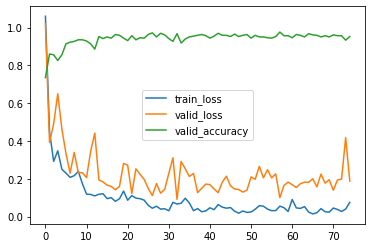

In [71]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeRandomSwap

In [72]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeRandomSwap', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.074586398767154
TEST
loss: 0.6627884129042266
accuracy: 0.8
******************
epoch: 1
Train
0.4046039461896955
TEST
loss: 0.2950389255759537
accuracy: 0.896774193548387
******************
epoch: 2
Train
0.2823369438826685
TEST
loss: 0.3257725939314852
accuracy: 0.8989247311827957
******************
epoch: 3
Train
0.24910040924352667
TEST
loss: 0.6894534346877887
accuracy: 0.832258064516129
******************
epoch: 4
Train
0.233272665119582
TEST
loss: 0.18741415841605075
accuracy: 0.9505376344086022
******************
epoch: 5
Train
0.24023043998608873
TEST
loss: 0.6625728441822913
accuracy: 0.8559139784946237
******************
epoch: 6
Train
0.24411652167766532
TEST
loss: 0.25602954183855364
accuracy: 0.9161290322580645
******************
epoch: 7
Train
0.1337420160997023
TEST
loss: 0.16618047753969828
accuracy: 0.9505376344086022
******************
epoch: 8
Train
0.11772518387133547
TEST
loss: 0.3281812490955476
accuracy: 0.91827956989

In [73]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9621342512908778


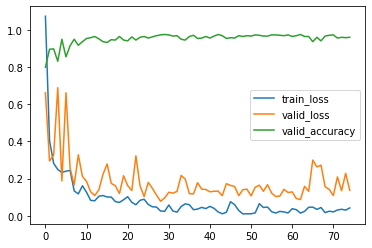

In [74]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqRandomSwap

In [75]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqRandomSwap', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.3614933217284368
TEST
loss: 0.8750335959978001
accuracy: 0.7096774193548387
******************
epoch: 1
Train
0.6586390026936816
TEST
loss: 0.3700200207771793
accuracy: 0.864516129032258
******************
epoch: 2
Train
0.43571944010790536
TEST
loss: 0.7108686841944213
accuracy: 0.7849462365591398
******************
epoch: 3
Train
0.40175880189216706
TEST
loss: 0.27260773239597197
accuracy: 0.9118279569892473
******************
epoch: 4
Train
0.30189234901000944
TEST
loss: 0.22262590963353393
accuracy: 0.9268817204301075
******************
epoch: 5
Train
0.310769095366914
TEST
loss: 0.8484981444574171
accuracy: 0.8129032258064516
******************
epoch: 6
Train
0.33797335367916603
TEST
loss: 0.22875166387968165
accuracy: 0.9333333333333333
******************
epoch: 7
Train
0.23890207307468386
TEST
loss: 0.35785210555599584
accuracy: 0.9118279569892473
******************
epoch: 8
Train
0.23130172494283335
TEST
loss: 0.3751517862401983
acc

In [76]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.963855421686747


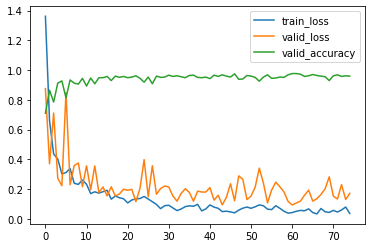

In [77]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()